## Seoul

In [4]:
CITY_NAME = "seoul"
CITY_BBOX = 126.760597, 37.422799, 127.190437, 37.709356

In [ ]:
# Seoul: https://bboxfinder.com/#37.439429,126.775360,37.693329,127.182884
# Paris: https://bboxfinder.com/#48.749172,2.155380,48.962187,2.538872

# New Delhi:    76.772461, 28.161110, 77.768372, 28.943516
# Seoul:        126.760597,37.422799,127.190437,37.709356
# Paris:        2.155380, 48.749172, 2.538872, 48.962187

# Los Angeles: -118.668153, 33.703935, -118.155358, 34.337306
# Nagoya:       136.822682, 35.058431, 137.050743, 35.233847

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
from pprint import pprint

import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

import matplotlib.pyplot as plt
import seaborn as sns

from openaq_anomaly_prediction.config import Configuration as config
from openaq_anomaly_prediction.utils.logging import logger, ProgressLogger
from openaq_anomaly_prediction.load.openaq import client as openaq, AreaDownloader

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 1000)

### Locations

In [4]:
city = AreaDownloader(area_name=CITY_NAME)
city.load_bbox(*CITY_BBOX)

logger.info(f"Area: {city.area_name.upper()}")
logger.info(f"Locations: {city.locations.shape}")
logger.info(f"Sensors: {city.sensors.shape}")

09:57:32     INFO |  Area: SEOUL
09:57:32     INFO |  Locations: (80, 25)
09:57:32     INFO |  Sensors: (469, 7)


Total number of sensors (no filtering): 469


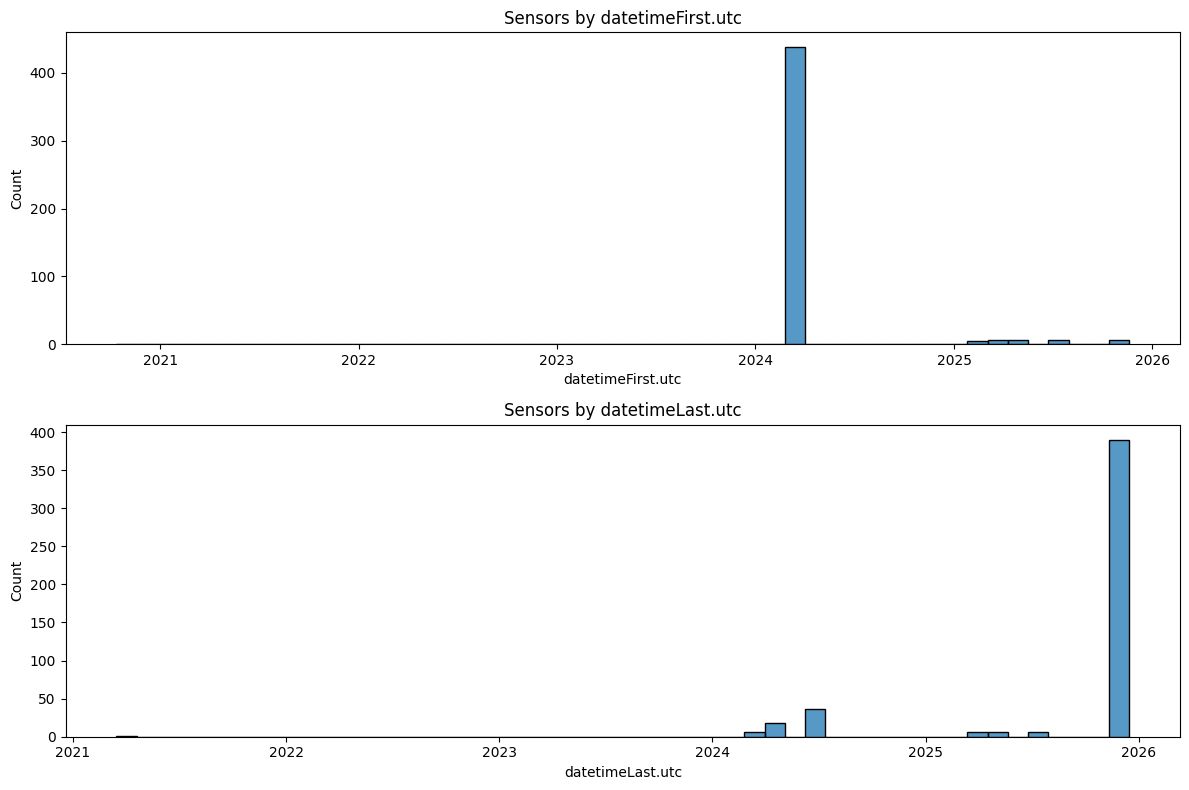

In [ ]:
# Plot the distribution of sensors by their location's datetimeFirst.utc and datetimeLast.utc
sensors_with_dates = city.get_sensors_with_dates()
print(f"Total number of sensors (no filtering): {len(sensors_with_dates)}")

fig, axes = plt.subplots(2, 1, figsize=(12, 6))
sns.histplot(sensors_with_dates, x="datetimeFirst.utc", bins=50, ax=axes[0])
axes[0].set_title("Sensors by datetimeFirst.utc")
sns.histplot(sensors_with_dates, x="datetimeLast.utc", bins=50, ax=axes[1])
axes[1].set_title("Sensors by datetimeLast.utc")
plt.tight_layout()
plt.show()

### Download Data: Measurements

In [ ]:
# --------------------------------------------------------------------------------------
# DOWNLOAD FROM OPENAQ API: Download measurements for filtered sensors in the date range

from openaq_anomaly_prediction.utils.helpers import get_trimestrial_periods

# Testing: clear rate limits
openaq.clear_ratelimits()

all_logs = []
years = [2024, 2025]
for year in years:
    # Get trimesters for the year
    trimesters = get_trimestrial_periods(year)

    for i, trimester in enumerate(trimesters):
        # Skip trimesters (if already downloaded)
        # if year == 2024 and i in [0, 1]:
        #     continue

        datetime_from = trimester[0]
        datetime_to = trimester[1]

        run_id_prefix = f"{CITY_NAME}_{year}_T{i + 1}"

        trimester_logs = city.download_period_from_area(
            datetime_from=datetime_from,
            datetime_to=datetime_to,
            run_id_prefix=run_id_prefix,
            run_label=f"T{i + 1}/{year}",
        )
        all_logs.append(trimester_logs)

00:34:42     INFO |  [SEOUL][T3/2024] Fetching all measurements...
00:34:42    DEBUG |  [START] Downloading data for 403 sensors...
00:34:42    TRACE |   󰘍 RUN_ID: seoul_2024_T3_2024-07-01_2024-09-30
00:34:42    TRACE |   󰘍 From: 2024-07-01T00:00:00+00:00, to: 2024-09-30T23:59:59+00:00
00:34:42    1/403 |   󰘍 Fetching measurements...         T3/2024 [sensor_id=8541530]

00:34:46    1/403 |   󰘍 100%: 2199/2199 measurements     T3/2024 [sensor_id=8541530]  | 4.65s: -> usd:3, rem:57, rst:57s  
00:34:50    2/403 |   󰘍 100%: 2199/2199 measurements     T3/2024 [sensor_id=8541478]  | 3.54s: -> usd:6, rem:54, rst:53s
00:34:54    3/403 |   󰘍 100%: 2199/2199 measurements     T3/2024 [sensor_id=8541418]  | 4.46s: -> usd:9, rem:51, rst:49s  
00:34:58    4/403 |   󰘍 100%: 2199/2199 measurements     T3/2024 [sensor_id=8541364]  | 3.88s: -> usd:12, rem:48, rst:45s
00:35:01    5/403 |   󰘍 100%: 2199/2199 measurements     T3/2024 [sensor_id=8533919]  | 2.93s: -> usd:1, rem:59, rst:60s 
00:35:04    6/403 |   󰘍 100%: 2199/2199 measurements     T3/2024 [sensor_id=8541561]  | 3.24s: -> usd:4, rem:56, rst:56s
00:35:07    7/403 |   󰘍 100%: 2199/2199 measurements     T3/2024 [sensor_id=8539591]  | 2.70s: -> usd:7, rem:53, rst:53s
00:35:12    8/403 |   󰘍 100%: 2199/2199 measurements     T3/2024 [sensor_id=8540451]  | 4.47s: -> usd:10, rem:50, rst:50s 
00:35:16    9/403 |   󰘍 

In [ ]:
# Summary of all download logs
AreaDownloader.print_period_logs(all_logs, True)

### Download Data: Weather History

In [ ]:
# Yep.

### Create STG file (CSV)

In [3]:
import glob
from openaq_anomaly_prediction.utils.helpers import concat_csv_to_csv
import os
# CONCATENATE: Concatenate several trimesters CSVs into a single CSV file

staging_csv_prefix = f"{CITY_NAME}_2025"

selected_files = glob.glob(os.path.join(config.DATA_CSV_PATH, f"{staging_csv_prefix}*.raw.csv"))
pprint(selected_files)

NameError: name 'CITY_NAME' is not defined

In [13]:
concat_csv_to_csv(selected_files, f"{staging_csv_prefix}.stg.csv")

09:54:03      4/4 |   󰘍 100%: Appending CSV files to final CSV -> data/csv/seoul_2025.stg.csv 


### Create INT file (Parquet)

In [7]:
staging_csv_path = os.path.join(config.DATA_CSV_PATH, f"{staging_csv_prefix}.stg.csv")

df_stg = pd.read_csv(staging_csv_path)
print(f"{staging_csv_prefix}: {df_stg.shape}")

seoul_2025: (3193431, 34)


In [8]:
df_int = city.get_clean_measurements(df_stg)

In [9]:
df_int.to_parquet(os.path.join(config.DATA_CSV_PATH, f"{staging_csv_prefix}_measurements.int.parquet"), index=False, compression='snappy')

### Optional: analyze logs

In [40]:
import json

CITY_NAME_LOGS = "paris"

city_logs = glob.glob(os.path.join(config.LOGS_PATH, f"{CITY_NAME_LOGS}*.json"))
# pprint(city_logs)

aborted_runs = []
for log_file in city_logs:

    sensor_ids = []
    with open(log_file, 'r') as f:
        log_data = f.read()
        data = json.loads(log_data)  # Validate JSON

        if data["status"] == "aborted":
            print(f"[ABORTED] {data['run_id']} (retries={data['retries']})")

            if data['logs'][-1]["status"] == "aborted":  # should always be true

                # I want to show the errors for each request
                for error in data['logs'][-1]["errors"]:
                    # print(error["error"]["message"])
                    # print(error["sensor_id"])
                    sensor_ids.append(error["sensor_id"])
            # Get last run
            # print(f"{data['logs'][-1]}")

            aborted_runs.append({
                "run_id": data['run_id'],
                "bad_sensors_count": len(sensor_ids),
                "sensor_ids": sensor_ids,
            })

        # print(f"Contents of {log_file}:\n{data}\n")


[ABORTED] paris_2023_T4_2023-10-01_2023-12-31 (retries=10)
[ABORTED] paris_2025_T4_2025-10-01_2025-12-31 (retries=10)
[ABORTED] paris_2021_T4_2021-10-01_2021-12-31 (retries=10)


In [41]:
aborted_runs

[{'run_id': 'paris_2023_T4_2023-10-01_2023-12-31',
  'bad_sensors_count': 3,
  'sensor_ids': [9593, 4275130, 9680]},
 {'run_id': 'paris_2025_T4_2025-10-01_2025-12-31',
  'bad_sensors_count': 42,
  'sensor_ids': [5620,
   5588,
   9542,
   9539,
   9643,
   9736,
   9610,
   9716,
   9609,
   9590,
   9589,
   9680,
   9625,
   4661655,
   9614,
   9637,
   9863,
   15298,
   9647,
   9646,
   9652,
   9671,
   9672,
   9693,
   9729,
   9747,
   9778,
   9777,
   9779,
   9782,
   9850,
   9851,
   9860,
   9861,
   7773042,
   7773850,
   7773420,
   7775825,
   10124847,
   10124849,
   10124824,
   10124825]},
 {'run_id': 'paris_2021_T4_2021-10-01_2021-12-31',
  'bad_sensors_count': 11,
  'sensor_ids': [9577,
   9609,
   9863,
   15298,
   9647,
   9646,
   9864,
   9652,
   9655,
   9662,
   9663]}]

In [ ]:
sensors = [
    4274492,
    5620,
    5588,
    4274992,
    9542,
    9539,
    9538,
    1582598,
    4275088,
    9643,
    9544,
    9548,
    4275047,
    9736,
    9564,
    4275502,
    9610,
    9577,
    9711,
    4275149,
    9716,
    9583,
    9588,
    4275214,
    9609,
    9590,
    9589,
    9630,
    4274657,
    9629,
    9593,
    4275130,
    9680,
    9597,
    1562368,
    4274782,
    9625,
    9608,
    4661655,
    9614,
    4275451,
    9637,
    4274884,
    9863,
    15298,
    9647,
    9646,
    9864,
    9660,
    4275042,
    9652,
    9651,
    4274737,
    9671,
    4274987,
    9672,
    4274481,
    9693,
    4274358,
    9729,
    4275077,
    9747,
    4274724,
    9778,
    9777,
    4274755,
    9779,
    9782,
    4274919,
    9850,
    9851,
    9854,
    4274683,
    9860,
    9861,
    7773042,
    7775534,
    7773850,
    7773420,
    7775307,
    7775825,
    10124847,
    10124844,
    10124849,
    10124824,
    10124825,
    14152704,
    14152705,
    14152706,
    14152707,
    14152708,
    14346050,
    14346051,
    14346052,
    14346053,
    14346054,
]